In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import gen_pyg_data, load_val_dataset

torch.manual_seed(1234)

lr = 3e-4
EPS = 1e-10
T=5
device = 'cuda:0'

In [2]:
def train_instance(model, optimizer, pyg_data, distances, n_ants):
    model.train()
    heu_vec = model(pyg_data)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    
    aco = ACO(
        n_ants=n_ants,
        heuristic=heu_mat,
        distances=distances,
        device=device
        )
    
    costs, log_probs = aco.sample()
    baseline = costs.mean()
    reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
    optimizer.zero_grad()
    reinforce_loss.backward()
    optimizer.step()

def infer_instance(model, pyg_data, distances, n_ants):
    model.eval()
    heu_vec = model(pyg_data)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO(
        n_ants=n_ants,
        heuristic=heu_mat,
        distances=distances,
        device=device
        )
    costs, log_probs = aco.sample()
    aco.run(n_iterations=T)
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_cost = aco.lowest_cost
    return baseline.item(), best_sample_cost.item(), best_aco_cost.item()

In [3]:
def train_epoch(n_node,
                n_ants, 
                k_sparse, 
                epoch, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    for _ in range(steps_per_epoch):
        instance = torch.rand(size=(n_node, 2), device=device)
        data, distances = gen_pyg_data(instance, k_sparse=k_sparse)
        train_instance(net, optimizer, data, distances, n_ants)


@torch.no_grad()
def validation(n_ants, epoch, net, val_dataset, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    
    for data, distances in val_dataset:
        bl, sample_best, aco_best = infer_instance(net, data, distances, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    
    n_val = len(val_dataset)
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    
    return avg_bl, avg_sample_best, avg_aco_best

In [4]:
def train(n_node, k_sparse, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    val_list = load_val_dataset(n_node, k_sparse, device)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_ants, -1, net, val_list, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, epoch, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_sample_best, avg_aco_best = validation(n_ants, epoch, net, val_list, animator)
        val_results.append((avg_bl, avg_sample_best, avg_aco_best))
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
        
    torch.save(net.state_dict(), f'../pretrained/tsp/tsp{n_node}.pt')

Learn heuristic for TSP20: 

total training duration: 68.66173219680786
epoch -1: (7.389515957832336, 6.151585960388184, 5.653606867790222)
epoch 0: (4.983130354881286, 4.283209140300751, 3.962330186367035)
epoch 1: (4.476540601253509, 3.951026213169098, 3.8490072774887083)
epoch 2: (4.351146795749664, 3.9194301557540894, 3.838328719139099)
epoch 3: (4.365202698707581, 3.90883412361145, 3.827320861816406)
epoch 4: (4.38464241027832, 3.9300931763648985, 3.84234961271286)


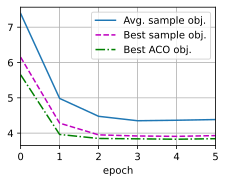

In [5]:
n_node, n_ants = 20, 20
k_sparse = 10
steps_per_epoch = 128
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Learn heuristic for TSP100: 

total training duration: 120.20243453979492
epoch -1: (21.443779048919676, 19.615448265075685, 18.82631748199463)
epoch 0: (13.097439441680908, 11.753785648345946, 10.807051305770875)
epoch 1: (10.070752849578858, 9.330580339431762, 8.833520278930663)
epoch 2: (9.818960437774658, 9.07780930519104, 8.626941604614258)
epoch 3: (9.721839113235474, 8.991541881561279, 8.594109416007996)
epoch 4: (9.711450233459473, 9.026623315811158, 8.63921733379364)


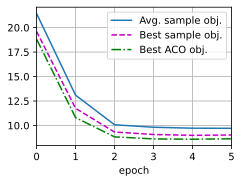

In [6]:
n_node = 100
n_ants = 20
k_sparse = 20
steps_per_epoch = 128
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Learn heuristic for TSP500: 

total training duration: 472.1851406097412
epoch -1: (69.15739501953125, 65.84911876678467, 64.88369365692138)
epoch 0: (27.6236510848999, 26.075670528411866, 24.09028289794922)
epoch 1: (23.90336416244507, 22.48627794265747, 21.41227710723877)
epoch 2: (23.06234348297119, 21.618331356048586, 20.543487224578858)
epoch 3: (22.123531036376953, 20.900113105773926, 19.917785358428954)
epoch 4: (21.94193012237549, 20.73219964981079, 19.791852359771728)


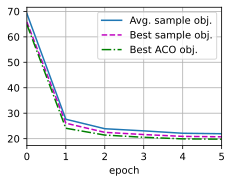

In [7]:
n_node = 500
n_ants = 50
k_sparse = 50
steps_per_epoch = 128
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)